In [ ]:
# 1. Subir tu archivo CSV a Colab
from google.colab import files
uploaded = files.upload()  # Selecciona 'peces_canal_panama_ML_limpio.csv'

# 2. Instalar librerías necesarias
!pip install scikit-bio  # Para análisis ecológicos (Bray-Curtis, etc.)
!pip install scipy       # Ya viene con Colab, pero verificar

# 3. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Saving peces_canal_panama_ML_limpio.csv to peces_canal_panama_ML_limpio (1).csv
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 67.6 MB/s eta 0:00:00


In [ ]:
# Leer CSV
df = pd.read_csv('peces_canal_panama_ML_limpio.csv')

# Filtrar solo registros con abundancias positivas
df_clean = df[(df['TOTAL'] > 0) & (df['AÑO'].notna()) & (df['Especies'].notna())].copy()

print(f"📌 Datos cargados: {len(df_clean):,} registros")
print(f"📅 Años: {sorted(df_clean['AÑO'].unique())}")
print(f"🐟 Especies únicas: {df_clean['Especies'].nunique()}")

📌 Datos cargados: 18,167 registros
📅 Años: [np.int64(2004), np.int64(2005), np.int64(2011), np.int64(2016), np.int64(2018), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
🐟 Especies únicas: 115


PASO 2: Crear Matriz de Comunidades (Año × Especies)

In [ ]:
# Agregar abundancias por año y especie
community_matrix = df_clean.groupby(['AÑO', 'Especies'])['TOTAL'].sum().unstack(fill_value=0)

print(f"Dimensiones de la matriz: {community_matrix.shape}")
print(f"(filas=años, columnas=especies)")

# Visualizar estructura
community_matrix.head()

Dimensiones de la matriz: (11, 115)
(filas=años, columnas=especies)


Especies,"Achirus mazatlanus (Steindachner, 1869)","Albula vulpes (Linnaeus, 1758)","Amatitlania nigrofasciata (Günther, 1867)","Anchoa panamensis (Steindachner, 1876)","Anchoa parva (Meek & Hildebrand, 1923)","Anchoa spinifer (Valenciennes, 1848)","Andinoacara coeruleopunctatus (Kner, 1863)",Ariopsis sp,"Astronotus ocellatus (Agassiz, 1831)","Astronotus ocellatus (agassiz, 1831)",...,"Rhonciscus crocro (Cuvier, 1830)","Roeboides bouchellei Fowler, 1923","Roeboides guatemalensis (Günther, 1864)","Roeboides ilseae Bussing, 1986","Roeboides occidentalis Meek & Hildebrand, 1916","Sicydium altum Meek, 1907","Sicydium salvini Ogilvie-Grant, 1884","Synbranchus marmoratus Bloch, 1795","Trichopsetta caribbaea Anderson & Gutherz, 1967","Vieja maculicauda (Regan, 1905)"
AÑO,,,,,,,,,,,,,,,,,,,,,
2004,259,0,37,0,0,0,0,0,296,0,...,0,0,0,518,0,0,0,37,0,444
2005,0,296,0,0,0,37,333,0,0,0,...,0,37,0,0,407,0,0,0,0,185
2011,0,0,0,0,0,0,0,0,37,0,...,0,0,0,0,0,0,37,0,0,74
2016,0,0,0,0,0,0,0,0,37,0,...,0,0,0,0,0,0,0,0,0,185
2018,0,0,0,0,259,0,0,0,74,0,...,0,0,222,0,0,185,0,37,0,407


PASO 3: Calcular Índice de Simpson

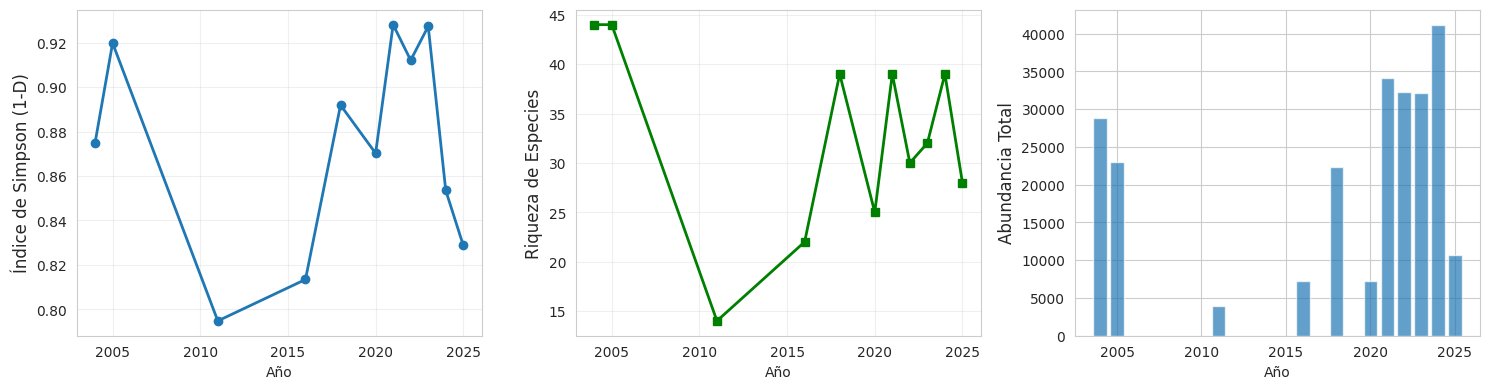

      Year  Simpson_Diversity  Richness  Total_Abundance
AÑO                                                     
2004  2004           0.874899        44            28897
2005  2005           0.919818        44            23051
2011  2011           0.794767        14             3922
2016  2016           0.813412        22             7215
2018  2018           0.891895        39            22385
2020  2020           0.870211        25             7289
2021  2021           0.928103        39            34188
2022  2022           0.912073        30            32227
2023  2023           0.927363        32            32153
2024  2024           0.853480        39            41107
2025  2025           0.828751        28            10730


In [ ]:
def simpson_diversity(row):
    """Calcula 1-D (diversidad de Simpson)"""
    N = row.sum()
    if N == 0:
        return 0
    p = row / N  # Proporciones
    return 1 - (p**2).sum()

# Calcular por año
diversity_df = pd.DataFrame({
    'Year': community_matrix.index,
    'Simpson_Diversity': community_matrix.apply(simpson_diversity, axis=1),
    'Richness': (community_matrix > 0).sum(axis=1),
    'Total_Abundance': community_matrix.sum(axis=1)
})

# Visualizar
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(diversity_df['Year'], diversity_df['Simpson_Diversity'], 'o-', linewidth=2)
axes[0].set_ylabel('Índice de Simpson (1-D)', fontsize=12)
axes[0].set_xlabel('Año')
axes[0].grid(alpha=0.3)

axes[1].plot(diversity_df['Year'], diversity_df['Richness'], 's-', color='green', linewidth=2)
axes[1].set_ylabel('Riqueza de Especies', fontsize=12)
axes[1].set_xlabel('Año')
axes[1].grid(alpha=0.3)

axes[2].bar(diversity_df['Year'], diversity_df['Total_Abundance'], alpha=0.7)
axes[2].set_ylabel('Abundancia Total', fontsize=12)
axes[2].set_xlabel('Año')

plt.tight_layout()
plt.show()

print(diversity_df)

PASO 4: Análisis de Ordenación (NMDS o PCA)
¿Qué método prefieres?

PCA: Más rápido, asume relaciones lineales
NMDS: Más robusto para datos ecológicos, usa disimilaridades (Bray-Curtis)

Opción A: NMDS (recomendado para comunidades)

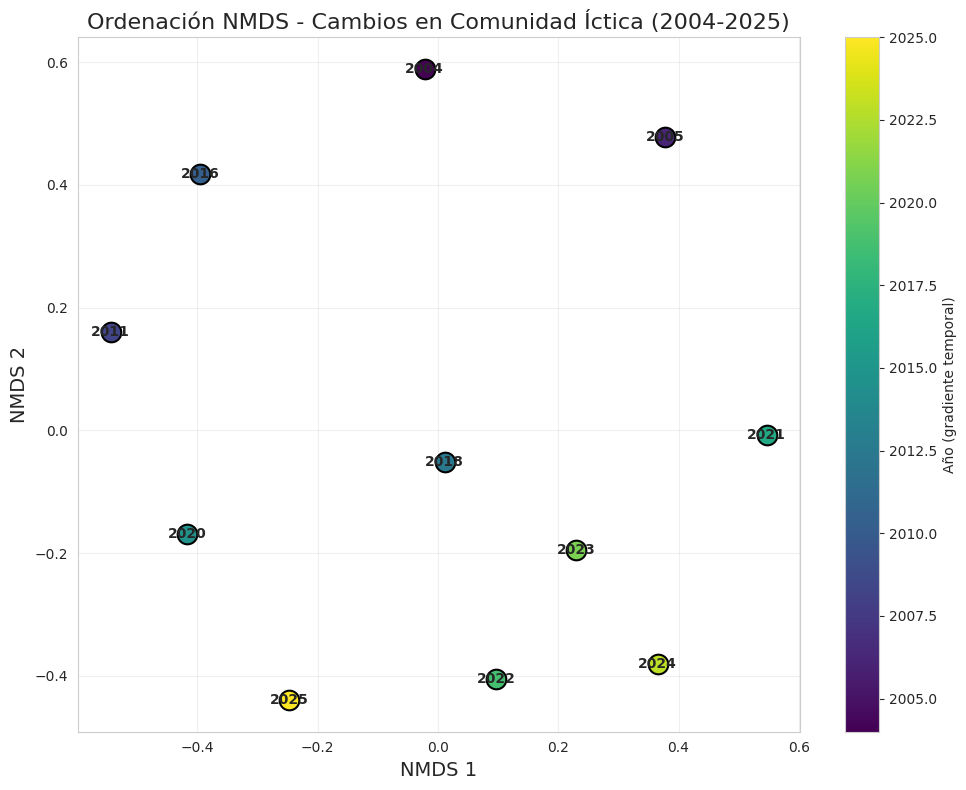

Stress del NMDS: 1.645
(Stress < 0.2 = buena representación)


In [ ]:
from sklearn.manifold import MDS
from matplotlib.colors import Normalize

# Calcular matriz de disimilaridad de Bray-Curtis
def bray_curtis_matrix(matrix):
    """Bray-Curtis entre filas (años)"""
    from scipy.spatial.distance import pdist, squareform
    bc_dist = pdist(matrix, metric='braycurtis')
    return squareform(bc_dist)

bc_matrix = bray_curtis_matrix(community_matrix.values)

# NMDS (MDS con distancias Bray-Curtis)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
nmds_coords = mds.fit_transform(bc_matrix)

# Visualizar
plt.figure(figsize=(10, 8))
years = community_matrix.index
colors = plt.cm.viridis(np.linspace(0, 1, len(years)))

for i, (year, color) in enumerate(zip(years, colors)):
    plt.scatter(nmds_coords[i, 0], nmds_coords[i, 1],
                s=200, color=color, edgecolor='black', linewidth=1.5)
    plt.text(nmds_coords[i, 0], nmds_coords[i, 1], str(year),
             fontsize=10, ha='center', va='center', fontweight='bold')

plt.xlabel('NMDS 1', fontsize=14)
plt.ylabel('NMDS 2', fontsize=14)
plt.title('Ordenación NMDS - Cambios en Comunidad Íctica (2004-2025)', fontsize=16)
plt.grid(alpha=0.3)

# FIX DEL COLORBAR:
norm = Normalize(vmin=min(years), vmax=max(years))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label='Año (gradiente temporal)')

plt.tight_layout()
plt.show()

print(f"Stress del NMDS: {mds.stress_:.3f}")
print("(Stress < 0.2 = buena representación)")

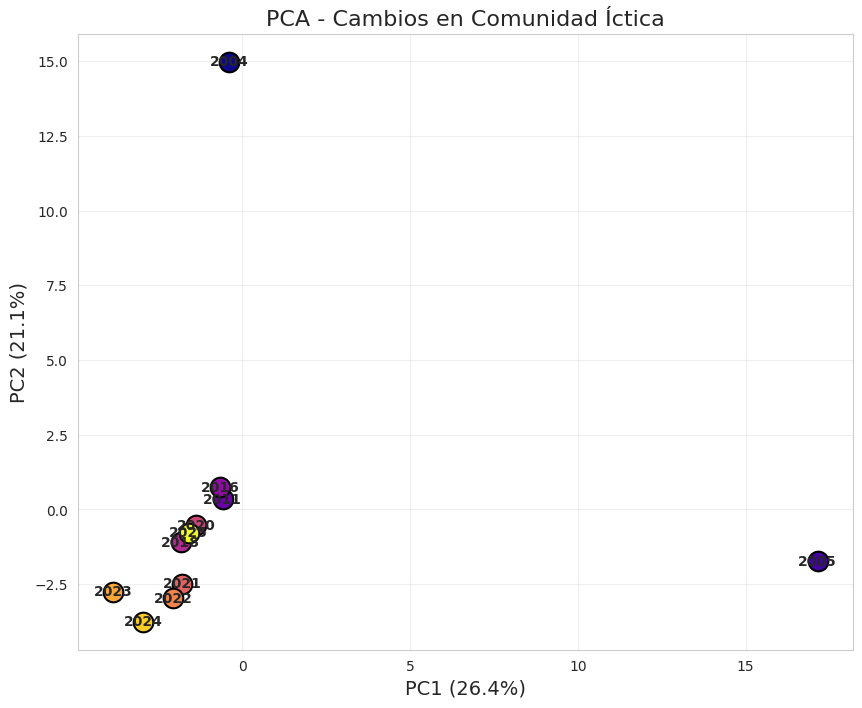

Varianza explicada PC1: 26.4%
Varianza explicada PC2: 21.1%


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Estandarizar (importante para PCA)
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(community_matrix)

# PCA
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(matrix_scaled)

# Visualizar (código similar al NMDS arriba)
plt.figure(figsize=(10, 8))
years = community_matrix.index
colors = plt.cm.plasma(np.linspace(0, 1, len(years)))

for i, (year, color) in enumerate(zip(years, colors)):
    plt.scatter(pca_coords[i, 0], pca_coords[i, 1],
                s=200, color=color, edgecolor='black', linewidth=1.5)
    plt.text(pca_coords[i, 0], pca_coords[i, 1], str(year),
             fontsize=10, ha='center', va='center', fontweight='bold')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=14)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=14)
plt.title('PCA - Cambios en Comunidad Íctica', fontsize=16)
plt.grid(alpha=0.3)
plt.show()

print(f"Varianza explicada PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"Varianza explicada PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")

PASO 5: Identificar Especies Indicadoras de Cambio

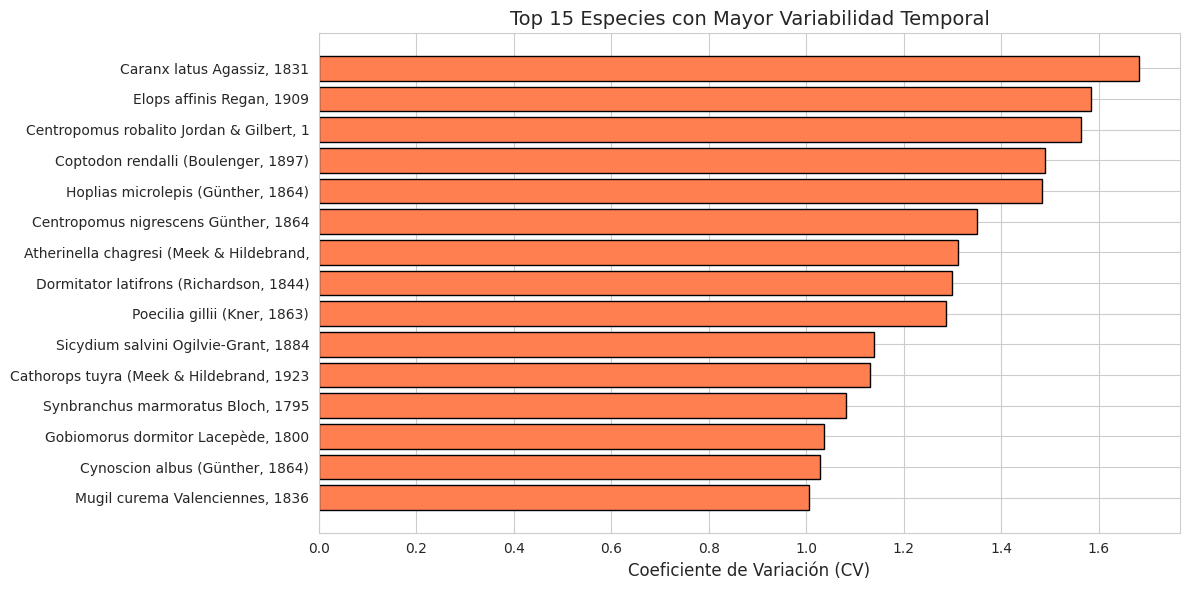

🔍 Especies más variables (posibles indicadores de cambio climático):
                                           Especie        CV  \
6                       Caranx latus Agassiz, 1831  1.683080   
19                       Elops affinis Regan, 1909  1.584282   
9      Centropomus robalito Jordan & Gilbert, 1882  1.565045   
12             Coptodon rendalli (Boulenger, 1897)  1.489686   
28              Hoplias microlepis (Günther, 1864)  1.484609   
8             Centropomus nigrescens Günther, 1864  1.350373   
2   Atherinella chagresi (Meek & Hildebrand, 1914)  1.311096   
16         Dormitator latifrons (Richardson, 1844)  1.299987   
38                    Poecilia gillii (Kner, 1863)  1.287700   
40            Sicydium salvini Ogilvie-Grant, 1884  1.139871   
7        Cathorops tuyra (Meek & Hildebrand, 1923)  1.130860   
41              Synbranchus marmoratus Bloch, 1795  1.082532   
27              Gobiomorus dormitor Lacepède, 1800  1.035555   
13                 Cynoscion albus 

In [ ]:
# Especies con mayor variación temporal (coeficiente de variación)
species_cv = []

for species in community_matrix.columns:
    abundances = community_matrix[species]
    non_zero = abundances[abundances > 0]

    if len(non_zero) >= 3:  # Necesita estar presente en al menos 3 años
        cv = non_zero.std() / non_zero.mean()
        species_cv.append({
            'Especie': species,
            'CV': cv,
            'Abundancia_Media': non_zero.mean(),
            'Años_Presente': len(non_zero)
        })

cv_df = pd.DataFrame(species_cv).sort_values('CV', ascending=False).head(15)

# Visualizar
plt.figure(figsize=(12, 6))
plt.barh(range(len(cv_df)), cv_df['CV'], color='coral', edgecolor='black')
plt.yticks(range(len(cv_df)), cv_df['Especie'].str[:40])
plt.xlabel('Coeficiente de Variación (CV)', fontsize=12)
plt.title('Top 15 Especies con Mayor Variabilidad Temporal', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("🔍 Especies más variables (posibles indicadores de cambio climático):")
print(cv_df)